# Setting

In [ ]:
!pip uninstall transformers huggingface_hub accelerate torchao -y -q
!pip install transformers==4.36.2 -q
!pip install huggingface_hub
!pip install accelerate -q
!pip install datasets --upgrade -q
!pip install fsspec --upgrade -q

Uninstalling existing transformers and related packages to ensure clean state...
Installing a specific stable version of transformers (e.g., 4.36.2)...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 109.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.15.2 requires accelerate>=0.21.0, which is not installed.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.datasets import imdb

import config
from dataset import SentimentDataset, load_naver_shopping_reviews, load_imdb_data, load_sst2_data
from model import FeatureExtractor, SentimentClassifier, DomainDiscriminator
from trainer import train_epoch, evaluate_target
from utils import clean_korean_text

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cache_dir = os.path.expanduser("~/.cache/huggingface/datasets")

if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)

project_path= '/content/drive/MyDrive/DA' # .py 파일들이 있는 내 드라이브 폴더 경로
sys.path.append(project_path)

Attempting to clear Hugging Face datasets cache directory: /root/.cache/huggingface/datasets
Hugging Face datasets cache directory not found (this is okay if it's the first run or cache is already clean).

Updating 'datasets' and 'fsspec' libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.2 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 4.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

In [ ]:
file_path = '/content/drive/MyDrive/DA/Train_target.csv'

df_sample = pd.read_csv(file_path, sep='\t', header=None, nrows=5)
print("--- File Sample (first 5 rows) ---")
print(df_sample)

df_full_check = pd.read_csv(file_path, sep='\t', header=None)
print(f"\n--- File Shape (rows, columns) ---")
print(df_full_check.shape)

--- File Sample (first 5 rows) ---
                                                   0
0                                         label,text
1  0,오버핏을 넘어선 아재핏으로 가봅니다 183 85키로인데 XL시켯는데 반품하기 귀...
2                      1,벽에 못 자국 안나고 바로 붙일 수 있어서 좋아요
3  0,이런걸 보내주니 참... 한두개도아니고 모르고 먹다 까만구멍잇길래 벌레가먹엇나 ...
4                1,완죤 대박입니다.튼튼하구 디자인두 굿. 좋은제품 감사합니다.

--- File Shape (rows, columns) ---
(180001, 1)


# DANN + Free Match

## DANN

In [ ]:
# config.py: 전체 프로젝트 설정값(모델, 학습, 데이터 등)을 관리하는 설정 파일
# utils.py:	GRL 정의 및 텍스트 전처리, alpha 스케줄링 함수 등 유틸 함수 모음
# dataset.py	소스/타겟 감정 데이터 로드 및 도메인 레이블 포함 데이터셋 구성
# model.py	DANN 모델 구성: 특징 추출기, 감정 분류기, 도메인 판별기 정의
# trainer.py	도메인 적응 학습 루프 및 타겟/소스 평가 함수 구현

In [ ]:
def run_on_colab():
    global project_path
    print(f"Using device: {config.DEVICE}")

    # --- 1. Load Tokenizer ---
    tokenizer = AutoTokenizer.from_pretrained(config.BERT_MODEL_NAME)

    # --- 2. Load Data ---
    print("Loading source (English) data...")
    # IMDB 전체 데이터 로드
    source_texts, source_labels = load_imdb_data(sample_size=config.SOURCE_DATA_SAMPLE_SIZE) # sample_size=None 전달
    print(f"Loaded {len(source_texts)} IMDB samples (full dataset).")

    if config.ADD_SST_TO_SOURCE:
        print("Attempting to load SST data...")
        sst_texts, sst_labels = [], []
        if config.USE_SST2_HF:
            # SST 전체 데이터 로드 (주로 train 스플릿 사용)
            sst_texts, sst_labels = load_sst2_data(sample_size=config.SST_SAMPLE_SIZE, split='train') # sample_size=None 전달
        else:
            # (파일 직접 파싱 로직 - 필요시 sample_size=None 처리)
            pass

        if sst_texts:
            source_texts.extend(sst_texts)
            source_labels.extend(sst_labels)
            print(f"Added {len(sst_texts)} SST samples (full dataset). Total source samples: {len(source_texts)}")

    source_dataset = SentimentDataset(source_texts, source_labels, tokenizer, config.MAX_LEN, is_source=True)
    source_loader = DataLoader(source_dataset, batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True) # drop_last=True 유지 또는 False 고려

    # --- 타겟(한국어) 데이터 로드 (학습용/평가용 파일 별도 사용) ---
    print("Loading target (Korean) training data...")
    target_train_file_path = f"{project_path}/{config.NAVER_SHOPPING_TRAIN_FILE}"
    target_train_texts, target_train_labels = load_naver_shopping_reviews(
        target_train_file_path,
        sample_size=100000  #config.TARGET_DATA_SAMPLE_SIZE # sample_size=None 전달 (파일 전체 사용)
    )
    print(f"Loaded {len(target_train_texts)} target training samples.")
    target_train_dataset = SentimentDataset(target_train_texts, target_train_labels, tokenizer, config.MAX_LEN, is_source=False)
    target_train_loader = DataLoader(target_train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True) # drop_last=True 유지 또는 False 고려

    print("Loading target (Korean) test data...")
    target_test_file_path = f"{project_path}/{config.NAVER_SHOPPING_TEST_FILE}"
    target_test_texts, target_test_labels = load_naver_shopping_reviews(
        target_test_file_path,
        sample_size=config.TARGET_DATA_SAMPLE_SIZE # sample_size=None 전달 (파일 전체 사용)
    )
    print(f"Loaded {len(target_test_texts)} target test samples.")
    target_test_dataset = SentimentDataset(target_test_texts, target_test_labels, tokenizer, config.MAX_LEN, is_source=False)
    target_test_loader = DataLoader(target_test_dataset, batch_size=config.BATCH_SIZE, shuffle=False) # 테스트 로더는 shuffle=False

    # --- (모델 초기화, 옵티마이저, 학습 루프 등 나머지 코드는 거의 동일하게 유지) ---
    # len_total_iters_epoch 계산 시 주의:
    # source_loader와 target_train_loader의 길이가 다를 수 있음 (학습 시 짧은 쪽 기준)
    if source_loader and target_train_loader:
        len_total_iters_epoch = min(len(source_loader), len(target_train_loader))
    else: # 하나라도 비어있으면 학습 불가 또는 다른 처리 필요
        print("Error: Source or Target train loader is not available. Cannot determine iterations per epoch.")
        return None, None, None, None, None, None, None, None # 함수 시그니처에 맞게 반환값 조정

    # --- 3. Initialize Models ---
    feature_extractor = FeatureExtractor(config.BERT_MODEL_NAME).to(config.DEVICE)
    sentiment_classifier = SentimentClassifier(feature_extractor.bert_output_dim).to(config.DEVICE)
    domain_discriminator = DomainDiscriminator(feature_extractor.bert_output_dim).to(config.DEVICE)

    # --- 4. Optimizer and Loss Functions ---
    optimizer = optim.AdamW(
        list(feature_extractor.parameters()) +
        list(sentiment_classifier.parameters()) +
        list(domain_discriminator.parameters()),
        lr=config.LEARNING_RATE
    )
    sentiment_criterion = nn.CrossEntropyLoss().to(config.DEVICE)
    # traceback에 BCEWithLogitsLoss가 있었으므로 다시 BCEWithLogitsLoss로 변경합니다.
    domain_criterion = nn.BCEWithLogitsLoss().to(config.DEVICE)

    # --- 5. Training Loop ---
    print("Starting DANN training in Colab...")
    for epoch in range(5):
        print(f"--- Epoch {epoch+1}/{config.EPOCHS} ---")
        avg_sent_loss, avg_dom_loss, avg_comb_loss = train_epoch(
            feature_extractor, sentiment_classifier, domain_discriminator,
            source_loader, target_train_loader, optimizer,
            sentiment_criterion, domain_criterion, config.DEVICE,
            epoch, config.EPOCHS, config.LAMBDA_ADVERSARIAL,
            config.SCHEDULE_GRL_ALPHA, len_total_iters_epoch
        )
        print(f"Epoch {epoch+1} Avg Losses: Sent={avg_sent_loss:.4f}, Dom={avg_dom_loss:.4f}, Comb={avg_comb_loss:.4f}")

        evaluate_target(feature_extractor, sentiment_classifier, target_test_loader, config.DEVICE, epoch)

    print("Training finished.")

    return feature_extractor, sentiment_classifier, domain_discriminator, source_loader, target_train_loader, target_test_loader, \
           config.DEVICE

if 'google.colab' in sys.modules:
   (feature_extractor, sentiment_classifier, domain_discriminator,
    source_loader, target_train_loader, target_test_loader,
    DEVICE) = run_on_colab()

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading source (English) data...


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Loaded 25000 IMDB samples (full dataset).
Attempting to load SST data...


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Loaded 67349 samples from SST-2 'train' split.
Added 67349 SST samples (full dataset). Total source samples: 92349
Loading target (Korean) training data...
Attempting to load: /content/drive/MyDrive/DA/Train_target.csv
Initial rows: 180000, Columns: ['label', 'text']
Loaded and processed 100000 samples from /content/drive/MyDrive/DA/Train_target.csv.
Loaded 100000 target training samples.
Loading target (Korean) test data...
Attempting to load: /content/drive/MyDrive/DA/Valid_target.csv
Initial rows: 5000, Columns: ['label', 'text']
Loaded and processed 5000 samples from /content/drive/MyDrive/DA/Valid_target.csv.
Loaded 5000 target test samples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Starting DANN training in Colab...
--- Epoch 1/5 ---
  Epoch 1, Batch 1155/5771, GRL alpha: 0.0997
  SentLoss: 0.5324, DomLoss: 1.3078 (weight: 0.15), CombLoss: 0.7285
  Epoch 1, Batch 2310/5771, GRL alpha: 0.1975
  SentLoss: 0.3330, DomLoss: 1.3431 (weight: 0.15), CombLoss: 0.5345
  Epoch 1, Batch 3465/5771, GRL alpha: 0.2915
  SentLoss: 0.2134, DomLoss: 1.4144 (weight: 0.15), CombLoss: 0.4256
  Epoch 1, Batch 4620/5771, GRL alpha: 0.3802
  SentLoss: 0.2064, DomLoss: 1.4076 (weight: 0.15), CombLoss: 0.4175
Epoch 1 Avg Losses: Sent=0.3022, Dom=1.3855, Comb=0.5100

--- Epoch 1 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.88      0.82      0.85      2501
      긍정 (1)       0.83      0.89      0.86      2499

    accuracy                           0.85      5000
   macro avg       0.86      0.85      0.85      5000
weighted avg       0.86      0.85      0.85      5000

Target Accuracy: 0.8546, Macro F1-score: 0.8544
-------

In [ ]:
model_save_dir = f"{project_path}/saved_models/" # Assuming project_path is defined

# Create the directory if it doesn't exist
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
    print(f"Created directory: {model_save_dir}")

# Define the file paths for each model
feature_extractor_path = os.path.join(model_save_dir, "feature_extractor_dann.pth")
sentiment_classifier_path = os.path.join(model_save_dir, "sentiment_classifier_dann.pth")
domain_discriminator_path = os.path.join(model_save_dir, "domain_discriminator_dann.pth")

# Save the state dictionaries of the models
try:
    torch.save(feature_extractor.state_dict(), feature_extractor_path)
    print(f"Feature Extractor model saved to: {feature_extractor_path}")

    torch.save(sentiment_classifier.state_dict(), sentiment_classifier_path)
    print(f"Sentiment Classifier model saved to: {sentiment_classifier_path}")

    torch.save(domain_discriminator.state_dict(), domain_discriminator_path)
    print(f"Domain Discriminator model saved to: {domain_discriminator_path}")

except Exception as e:
    print(f"Error saving models: {e}")

Error saving models: name 'feature_extractor' is not defined


In [ ]:
DEVICE = device
if 'model_save_dir' not in globals():
     model_save_dir = f"{project_path}/{getattr(config, 'MODEL_SAVE_DIR_BASE', 'saved_models')}"
     print(f"Model save/load directory set to: {model_save_dir}")

fe_weights_path = f"{model_save_dir}/feature_extractor_dann.pth" # 에폭 7에서 저장된 파일명
sc_weights_path = f"{model_save_dir}/sentiment_classifier_dann.pth" # 에폭 7에서 저장된 파일명

feature_extractor = FeatureExtractor(config.BERT_MODEL_NAME).to(DEVICE)
sentiment_classifier = SentimentClassifier(feature_extractor.bert_output_dim).to(DEVICE)

try:
    feature_extractor.load_state_dict(torch.load(fe_weights_path, map_location=DEVICE))
    sentiment_classifier.load_state_dict(torch.load(sc_weights_path, map_location=DEVICE))
    print(f"Successfully loaded saved weights for Model (from best performing epoch).")
except Exception as e:
    print(f"ERROR loading saved model weights for pseudo-labeling: {e}.")
    print("Cannot proceed without a teacher model. Please ensure model weights from Epoch 7 (or best) are correctly saved and paths are correct.")
    raise

Model save/load directory set to: /content/drive/MyDrive/DA/saved_models


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Successfully loaded saved weights for Model (from best performing epoch).


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config.BERT_MODEL_NAME)
test_texts, test_labels = load_naver_shopping_reviews(
    f"{project_path}/{config.NAVER_SHOPPING_TEST_FILE}",
    sample_size=None
)

target_test_dataset = SentimentDataset(
    test_texts,
    test_labels,
    tokenizer,
    config.MAX_LEN,
    is_source=False
)
target_test_loader = DataLoader(
    target_test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False
)

print(f"Test set size: {len(target_test_dataset)}   |   "
      f"Batches: {len(target_test_loader)}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Attempting to load: /content/drive/MyDrive/DA/Valid_target.csv
Initial rows: 5000, Columns: ['label', 'text']
Loaded and processed 5000 samples from /content/drive/MyDrive/DA/Valid_target.csv.
Test set size: 5000   |   Batches: 313


In [ ]:
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, average_precision_score,
                             accuracy_score, precision_score, recall_score, f1_score)

@torch.no_grad()
def evaluate_all_metrics(feature_extractor, sentiment_classifier,
                         test_loader, device, positive_class=1):
    feature_extractor.eval()
    sentiment_classifier.eval()

    y_true, y_pred, y_prob = [], [], []

    for batch in test_loader:
        input_ids  = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['sentiment_labels'].to(device)

        feats   = feature_extractor(input_ids, attention_mask)
        logits  = sentiment_classifier(feats)
        prob    = torch.softmax(logits, dim=-1)
        pred    = torch.argmax(prob, dim=-1)

        y_true.append(labels.cpu())
        y_pred.append(pred.cpu())
        y_prob.append(prob.cpu()[:, positive_class])

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    y_prob = torch.cat(y_prob).numpy()


    # 평가지표
    acc     = accuracy_score (y_true, y_pred)
    prec    = precision_score(y_true, y_pred, zero_division=0)
    rec     = recall_score   (y_true, y_pred, zero_division=0)
    f1      = f1_score       (y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score  (y_true, y_prob)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")

    print(f"[[TN FP]\n [FN TP]] =\n{cm}\n")
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

evaluate_all_metrics(
    feature_extractor,
    sentiment_classifier,
    target_test_loader,
    config.DEVICE
)

Accuracy : 0.8648
Precision: 0.8292
Recall   : 0.9188
F1-score : 0.8717
ROC-AUC  : 0.9354
[[TN FP]
 [FN TP]] =
[[2028  473]
 [ 203 2296]]

TN=2028, FP=473, FN=203, TP=2296

              precision    recall  f1-score   support

           0     0.9090    0.8109    0.8571      2501
           1     0.8292    0.9188    0.8717      2499

    accuracy                         0.8648      5000
   macro avg     0.8691    0.8648    0.8644      5000
weighted avg     0.8691    0.8648    0.8644      5000



## Free Match

In [ ]:
# loss_s (지도 학습 손실): 소스(영어) 데이터로 기본적인 감성 분류 능력을 유지하거나 약간 보강
# loss_u (비지도 학습 손실): 오직 타겟(한국어) 데이터만으로 계산

# feature extractor: FreeMatch에서는 "오직 한국어 감성 분석에 가장 유용한 특징은 무엇인가?"를 학습
# sentiment_classifier: feature_extractor가 생성해주는, 한국어에 더 특화된 특징들을 입력받아 긍정/부정을 더 정확하게 분류하도록 결정 경계(decision boundary)를 미세 조정

In [ ]:
# 1. FreeMatch용 하이퍼파라미터
PSEUDO_EPOCHS = 15
LEARNING_RATE = 1e-6
EMA_DECAY = 0.999               # FreeMatch 논문 기본값
W_PSEUDO = 0.7                  # 유사 레이블 손실 가중치

# 불안정성을 유발했던 Fairness Loss 비활성화 (class 별 불균형 조정하기 위해 필요한 하이퍼파라미터)
W_FAIRNESS = 0.0

# 임계값이 폭주하는 것을 막기 위해 범위 제한
USE_THRESHOLD_CLAMP = True
CLAMP_MIN = 0.8
CLAMP_MAX = 0.95

# 모델 저장 경로 설정
MODEL_SAVE_PATH = f"{project_path}/saved_models/freematch_best/"
print(f"Hyperparameters set. Best model will be saved to: {MODEL_SAVE_PATH}")

# 2. FreeMatch 학습 함수 정의
def train_freematch_epoch(
    feature_extractor, sentiment_classifier,
    source_loader, unlabeled_target_loader,
    optimizer, sentiment_criterion, fairness_criterion,
    device, ema_decay, w_pseudo, w_fairness,
    global_confidence_ema, local_confidence_ema, pseudo_label_hist_ema
):
    """FreeMatch를 위한 안정화된 한 에폭 학습 함수"""
    feature_extractor.train()
    sentiment_classifier.train()

    total_loss, total_s_loss, total_u_loss, total_f_loss = 0, 0, 0, 0

    len_dataloader = min(len(source_loader), len(unlabeled_target_loader))
    source_iter = iter(source_loader)
    target_iter = iter(unlabeled_target_loader)

    for _ in tqdm(range(len_dataloader), desc="FreeMatch Epoch", leave=False):
        s_batch = next(source_iter)
        u_batch = next(target_iter)

        s_inputs, s_labels = s_batch['input_ids'].to(device), s_batch['sentiment_labels'].to(device)
        s_masks = s_batch['attention_mask'].to(device)
        u_inputs_w, u_masks_w = u_batch['input_ids'].to(device), u_batch['attention_mask'].to(device)
        u_inputs_s, u_masks_s = u_batch['input_ids'].to(device), u_batch['attention_mask'].to(device)

        # ---------지도 학습 손실 -> 영어 리뷰 데이터를 모델에 넣어 예측하고, 실제 정답과 비교하여 loss_s를 계산------
        s_features = feature_extractor(s_inputs, s_masks)
        s_logits = sentiment_classifier(s_features)
        loss_s = sentiment_criterion(s_logits, s_labels)

        #---------- 비지도 학습 (FreeMatch)---------
        # u_inputs_w: (논문상 약한 증강 데이타), 원본 데이터 + 드롭아웃 A
        # u_inputs_s: (논문상 강한 증강 데이터), 원본 데이터 + 드롭아웃 B
        # 유사 레이블링
        with torch.no_grad():
            u_features_w = feature_extractor(u_inputs_w, u_masks_w)   # 레이블 없는 한국어 데이터(u_inputs_w,1차 증강 데이터)를 모델에 넣어 예측 확률 획득
            logits_u_w = sentiment_classifier(u_features_w)
            probs_u_w = torch.softmax(logits_u_w, dim=-1)
            max_probs, pseudo_labels = torch.max(probs_u_w, dim=-1)  # 가장 확률이 높은 클래스를 pseudo_labels로, 그때의 확률을 max_probs로

            # --- SAT 업데이트 --- : 자기 적응 임계값 계산
            global_confidence_ema = ema_decay * global_confidence_ema + (1 - ema_decay) * max_probs.mean()  # 이번 배치의 전체 평균 자신감
            local_confidence_ema = ema_decay * local_confidence_ema + (1 - ema_decay) * probs_u_w.mean(0)      # 이번 배치의 클래스별 평균 확률->클래스별 강점/약점 정도

            class_specific_threshold = global_confidence_ema * (local_confidence_ema / local_confidence_ema.max())   # 두 정보를 조합하여 클래스별 맞춤 임계치 설정

            # [안정성 장치] 임계값 범위 제한 (Clamping)
            if USE_THRESHOLD_CLAMP:
                class_specific_threshold = torch.clamp(class_specific_threshold, min=CLAMP_MIN, max=CLAMP_MAX)

            # 마스킹: 임계치보다 해당 샘플의 신뢰도가 크거나 같으면(ge: Greater or Equal) 1, 아니면 0인 mask를 생성
            mask = max_probs.ge(class_specific_threshold[pseudo_labels]).float()

        # 2차 증강 데이터로 예측 -> 이 예측이 (1차 증강된 데이터로 만든) pseudo_labels와 일치하는지 손실을 계산
        u_features_s = feature_extractor(u_inputs_s, u_masks_s)
        logits_u_s = sentiment_classifier(u_features_s)

        # 유사 레이블 손실
        loss_u = (F.cross_entropy(logits_u_s, pseudo_labels, reduction='none') * mask).mean()  # 마스크가 0인 샘플의 손실은 0이 되어 무시되고, 마스크가 1인 샘플의 손실만 평균

        # [안정성 장치] Fairness Loss 비활성화 (w_fairness가 0이므로 loss_f는 0이 됨)
        loss_f = torch.tensor(0.0, device=device)
        total_epoch_loss = loss_s + w_pseudo * loss_u + w_fairness * loss_f

        optimizer.zero_grad()
        total_epoch_loss.backward()
        optimizer.step()

        total_loss += total_epoch_loss.item()
        total_s_loss += loss_s.item()
        total_u_loss += loss_u.item()

    avg_loss = total_loss / len_dataloader
    avg_s_loss = total_s_loss / len_dataloader
    avg_u_loss = total_u_loss / len_dataloader

    return avg_loss, avg_s_loss, avg_u_loss, global_confidence_ema, local_confidence_ema

# 3. FreeMatch 실험 실행 메인 함수
def run_freematch_experiment_notebook(feature_extractor, sentiment_classifier):
    """DANN 모델을 인자로 받아 FreeMatch 학습을 수행합니다."""
    print(f"\n--- 2. Initializing FreeMatch Fine-tuning ---")

    tokenizer = AutoTokenizer.from_pretrained(config.BERT_MODEL_NAME)

    # 데이터 로더 준비
    source_texts, source_labels = load_imdb_data(sample_size=config.SOURCE_DATA_SAMPLE_SIZE)
    if config.ADD_SST_TO_SOURCE:
        sst_texts, sst_labels = load_sst2_data(sample_size=config.SST_SAMPLE_SIZE, split='train')
        source_texts.extend(sst_texts); source_labels.extend(sst_labels)

    source_dataset = SentimentDataset(source_texts, source_labels, tokenizer, config.MAX_LEN, is_source=True)
    source_loader = DataLoader(source_dataset, batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True)

    target_train_texts, _ = load_naver_shopping_reviews(f"{project_path}/{config.NAVER_SHOPPING_TRAIN_FILE}", sample_size=config.TARGET_DATA_SAMPLE_SIZE)
    target_test_texts, target_test_labels = load_naver_shopping_reviews(f"{project_path}/{config.NAVER_SHOPPING_TEST_FILE}", sample_size=None)

    unlabeled_target_dataset = SentimentDataset(target_train_texts, None, tokenizer, config.MAX_LEN, is_source=False)
    unlabeled_target_loader = DataLoader(unlabeled_target_dataset, batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True)

    target_test_dataset = SentimentDataset(target_test_texts, target_test_labels, tokenizer, config.MAX_LEN, is_source=False)
    target_test_loader = DataLoader(target_test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

    print(f"DataLoaders Ready for FreeMatch.")

    # 옵티마이저 및 손실 함수
    optimizer = optim.AdamW(list(feature_extractor.parameters()) + list(sentiment_classifier.parameters()), lr=LEARNING_RATE)
    sentiment_criterion = nn.CrossEntropyLoss().to(config.DEVICE)
    fairness_criterion = nn.KLDivLoss(reduction='batchmean').to(config.DEVICE)

    # EMA 변수 초기화
    num_classes = 2
    global_confidence_ema = torch.tensor(0.85, device=config.DEVICE) # 안정적인 시작을 위해 0.85로 warm-up
    local_confidence_ema = torch.ones(num_classes, device=config.DEVICE) / num_classes
    pseudo_label_hist_ema = torch.ones(num_classes, device=config.DEVICE) / num_classes

    # 학습 루프
    best_accuracy = 0.0
    print("\n--- 3. Starting FreeMatch Training Loop ---")
    for epoch in range(PSEUDO_EPOCHS):
        print(f"\n--- Epoch {epoch + 1}/{PSEUDO_EPOCHS} ---")

        avg_loss, s_loss, u_loss, g_ema, l_ema = train_freematch_epoch(
            feature_extractor, sentiment_classifier, source_loader, unlabeled_target_loader,
            optimizer, sentiment_criterion, fairness_criterion,
            config.DEVICE, EMA_DECAY, W_PSEUDO, W_FAIRNESS,
            global_confidence_ema, local_confidence_ema, pseudo_label_hist_ema
        )
        global_confidence_ema, local_confidence_ema = g_ema, l_ema

        print(f"Epoch {epoch+1} Avg Losses: Total={avg_loss:.4f}, Supervised={s_loss:.4f}, Unsupervised={u_loss:.4f}")
        print(f"Global Confidence EMA: {global_confidence_ema.item():.4f}")

        accuracy = evaluate_target(feature_extractor, sentiment_classifier, target_test_loader, config.DEVICE, epoch)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            print(f"New Best Accuracy: {best_accuracy:.4f}. Saving model to {MODEL_SAVE_PATH}...")
            if not os.path.exists(MODEL_SAVE_PATH):
                os.makedirs(MODEL_SAVE_PATH)
            torch.save(feature_extractor.state_dict(), f"{MODEL_SAVE_PATH}feature_extractor_freematch_best.pth")
            torch.save(sentiment_classifier.state_dict(), f"{MODEL_SAVE_PATH}sentiment_classifier_freematch_best.pth")

    print(f"\n--- FreeMatch Training Finished. Best Accuracy: {best_accuracy:.4f} ---")

# 4. 실행
if 'feature_extractor' in locals() and 'sentiment_classifier' in locals():
    run_freematch_experiment_notebook(feature_extractor, sentiment_classifier)
else:
    print("오류: DANN 모델이 메모리에 없습니다. DANN 학습을 먼저 실행해주세요.")

--- 1. Setting Hyperparameters for FreeMatch ---
Hyperparameters set. Best model will be saved to: /content/drive/MyDrive/DA/saved_models/freematch_best/

--- 2. Initializing FreeMatch Fine-tuning ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded 67349 samples from SST-2 'train' split.
Attempting to load: /content/drive/MyDrive/DA/Train_target.csv
Initial rows: 180000, Columns: ['label', 'text']
Loaded and processed 180000 samples from /content/drive/MyDrive/DA/Train_target.csv.
Attempting to load: /content/drive/MyDrive/DA/Valid_target.csv
Initial rows: 5000, Columns: ['label', 'text']
Loaded and processed 5000 samples from /content/drive/MyDrive/DA/Valid_target.csv.
DataLoaders Ready for FreeMatch.

--- 3. Starting FreeMatch Training Loop ---

--- Epoch 1/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 1 Avg Losses: Total=0.0794, Supervised=0.0527, Unsupervised=0.0380
Global Confidence EMA: 0.9749

--- Epoch 1 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.87      0.90      0.89      2501
      긍정 (1)       0.90      0.87      0.88      2499

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

Target Accuracy: 0.8864, Macro F1-score: 0.8864
---------------------------------------------------

New Best Accuracy: 0.8864. Saving model to /content/drive/MyDrive/DA/saved_models/freematch_best/...

--- Epoch 2/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 2 Avg Losses: Total=0.0623, Supervised=0.0435, Unsupervised=0.0268
Global Confidence EMA: 0.9786

--- Epoch 2 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.91      0.88      0.89      2501
      긍정 (1)       0.88      0.91      0.90      2499

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.89      5000
weighted avg       0.90      0.90      0.89      5000

Target Accuracy: 0.8950, Macro F1-score: 0.8950
---------------------------------------------------

New Best Accuracy: 0.8950. Saving model to /content/drive/MyDrive/DA/saved_models/freematch_best/...

--- Epoch 3/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 3 Avg Losses: Total=0.0543, Supervised=0.0383, Unsupervised=0.0229
Global Confidence EMA: 0.9813

--- Epoch 3 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.89      0.91      0.90      2501
      긍정 (1)       0.91      0.89      0.90      2499

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

Target Accuracy: 0.8992, Macro F1-score: 0.8992
---------------------------------------------------

New Best Accuracy: 0.8992. Saving model to /content/drive/MyDrive/DA/saved_models/freematch_best/...

--- Epoch 4/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 4 Avg Losses: Total=0.0487, Supervised=0.0340, Unsupervised=0.0210
Global Confidence EMA: 0.9831

--- Epoch 4 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.91      0.89      0.90      2501
      긍정 (1)       0.90      0.91      0.90      2499

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

Target Accuracy: 0.9010, Macro F1-score: 0.9010
---------------------------------------------------

New Best Accuracy: 0.9010. Saving model to /content/drive/MyDrive/DA/saved_models/freematch_best/...

--- Epoch 5/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 5 Avg Losses: Total=0.0436, Supervised=0.0312, Unsupervised=0.0177
Global Confidence EMA: 0.9843

--- Epoch 5 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.89      0.92      0.90      2501
      긍정 (1)       0.92      0.89      0.90      2499

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

Target Accuracy: 0.9026, Macro F1-score: 0.9026
---------------------------------------------------

New Best Accuracy: 0.9026. Saving model to /content/drive/MyDrive/DA/saved_models/freematch_best/...

--- Epoch 6/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 6 Avg Losses: Total=0.0407, Supervised=0.0290, Unsupervised=0.0167
Global Confidence EMA: 0.9853

--- Epoch 6 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.90      0.91      0.91      2501
      긍정 (1)       0.91      0.90      0.91      2499

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000

Target Accuracy: 0.9064, Macro F1-score: 0.9064
---------------------------------------------------

New Best Accuracy: 0.9064. Saving model to /content/drive/MyDrive/DA/saved_models/freematch_best/...

--- Epoch 7/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 7 Avg Losses: Total=0.0375, Supervised=0.0268, Unsupervised=0.0153
Global Confidence EMA: 0.9864

--- Epoch 7 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.91      0.91      0.91      2501
      긍정 (1)       0.91      0.91      0.91      2499

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000

Target Accuracy: 0.9060, Macro F1-score: 0.9060
---------------------------------------------------


--- Epoch 8/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 8 Avg Losses: Total=0.0347, Supervised=0.0245, Unsupervised=0.0145
Global Confidence EMA: 0.9871

--- Epoch 8 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.90      0.90      0.90      2501
      긍정 (1)       0.90      0.90      0.90      2499

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

Target Accuracy: 0.9040, Macro F1-score: 0.9040
---------------------------------------------------


--- Epoch 9/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 9 Avg Losses: Total=0.0333, Supervised=0.0233, Unsupervised=0.0143
Global Confidence EMA: 0.9881

--- Epoch 9 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.89      0.91      0.90      2501
      긍정 (1)       0.91      0.89      0.90      2499

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

Target Accuracy: 0.9006, Macro F1-score: 0.9006
---------------------------------------------------


--- Epoch 10/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 10 Avg Losses: Total=0.0306, Supervised=0.0213, Unsupervised=0.0133
Global Confidence EMA: 0.9876

--- Epoch 10 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.92      0.89      0.90      2501
      긍정 (1)       0.89      0.92      0.91      2499

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000

Target Accuracy: 0.9052, Macro F1-score: 0.9052
---------------------------------------------------


--- Epoch 11/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 11 Avg Losses: Total=0.0301, Supervised=0.0206, Unsupervised=0.0136
Global Confidence EMA: 0.9886

--- Epoch 11 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.90      0.91      0.91      2501
      긍정 (1)       0.91      0.90      0.90      2499

    accuracy                           0.91      5000
   macro avg       0.91      0.90      0.90      5000
weighted avg       0.91      0.91      0.90      5000

Target Accuracy: 0.9050, Macro F1-score: 0.9050
---------------------------------------------------


--- Epoch 12/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 12 Avg Losses: Total=0.0281, Supervised=0.0194, Unsupervised=0.0124
Global Confidence EMA: 0.9887

--- Epoch 12 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.90      0.91      0.90      2501
      긍정 (1)       0.91      0.89      0.90      2499

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

Target Accuracy: 0.9038, Macro F1-score: 0.9038
---------------------------------------------------


--- Epoch 13/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 13 Avg Losses: Total=0.0271, Supervised=0.0183, Unsupervised=0.0126
Global Confidence EMA: 0.9901

--- Epoch 13 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.91      0.90      0.90      2501
      긍정 (1)       0.90      0.91      0.90      2499

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

Target Accuracy: 0.9036, Macro F1-score: 0.9036
---------------------------------------------------


--- Epoch 14/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

Epoch 14 Avg Losses: Total=0.0254, Supervised=0.0176, Unsupervised=0.0111
Global Confidence EMA: 0.9907

--- Epoch 14 - Target (Korean) Test Results ---
              precision    recall  f1-score   support

      부정 (0)       0.90      0.91      0.90      2501
      긍정 (1)       0.91      0.90      0.90      2499

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

Target Accuracy: 0.9018, Macro F1-score: 0.9018
---------------------------------------------------


--- Epoch 15/15 ---


FreeMatch Epoch:   0%|          | 0/5771 [00:00<?, ?it/s]

In [ ]:
DEVICE = device
if 'model_save_dir' not in globals(): # 이전 셀에서 정의 안 됐을 경우 대비
     model_save_dir = f"{project_path}/{getattr(config, 'MODEL_SAVE_DIR_BASE', 'saved_models')}" # 실제 저장 경로로!
     print(f"Model save/load directory set to: {model_save_dir}")

fe_weights_path = f"{model_save_dir}/freematch_best/feature_extractor_freematch_best.pth"
sc_weights_path = f"{model_save_dir}/freematch_best/sentiment_classifier_freematch_best.pth"
feature_extractor = FeatureExtractor(config.BERT_MODEL_NAME).to(DEVICE)
sentiment_classifier = SentimentClassifier(feature_extractor.bert_output_dim).to(DEVICE)

try:
    feature_extractor.load_state_dict(torch.load(fe_weights_path, map_location=DEVICE))
    sentiment_classifier.load_state_dict(torch.load(sc_weights_path, map_location=DEVICE))
    print(f"Successfully loaded saved weights for Model (from best performing epoch).")
except Exception as e:
    print(f"ERROR loading saved model weights for pseudo-labeling: {e}.")
    print("Cannot proceed without a teacher model. Please ensure model weights from Epoch 7 (or best) are correctly saved and paths are correct.")
    raise

Model save/load directory set to: /content/drive/MyDrive/DA/saved_models


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Successfully loaded saved weights for Model (from best performing epoch).


In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from dataset import SentimentDataset, load_naver_shopping_reviews

tokenizer = AutoTokenizer.from_pretrained(config.BERT_MODEL_NAME)

test_texts, test_labels = load_naver_shopping_reviews(
    f"{project_path}/{config.NAVER_SHOPPING_TEST_FILE}",
    sample_size=None
)

# Dataset & DataLoader
target_test_dataset = SentimentDataset(
    test_texts,
    test_labels,
    tokenizer,
    config.MAX_LEN,
    is_source=False
)
target_test_loader = DataLoader(
    target_test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False
)

print(f"Test set size: {len(target_test_dataset)}   |   "
      f"Batches: {len(target_test_loader)}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Attempting to load: /content/drive/MyDrive/DA/Valid_target.csv
Initial rows: 5000, Columns: ['label', 'text']
Loaded and processed 5000 samples from /content/drive/MyDrive/DA/Valid_target.csv.
Test set size: 5000   |   Batches: 313


In [ ]:
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, average_precision_score,
                             accuracy_score, precision_score, recall_score, f1_score)

@torch.no_grad()
def evaluate_all_metrics(feature_extractor, sentiment_classifier,
                         test_loader, device, positive_class=1):
    feature_extractor.eval()
    sentiment_classifier.eval()
    y_true, y_pred, y_prob = [], [], []

    for batch in test_loader:
        input_ids  = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['sentiment_labels'].to(device)

        feats   = feature_extractor(input_ids, attention_mask)
        logits  = sentiment_classifier(feats)
        prob    = torch.softmax(logits, dim=-1)
        pred    = torch.argmax(prob, dim=-1)

        y_true.append(labels.cpu())
        y_pred.append(pred.cpu())
        y_prob.append(prob.cpu()[:, positive_class])

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    y_prob = torch.cat(y_prob).numpy()

    # 평가지표
    acc     = accuracy_score (y_true, y_pred)
    prec    = precision_score(y_true, y_pred, zero_division=0)
    rec     = recall_score   (y_true, y_pred, zero_division=0)
    f1      = f1_score       (y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score  (y_true, y_prob)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")
    print(f"[[TN FP]\n [FN TP]] =\n{cm}\n")
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

evaluate_all_metrics(
    feature_extractor,
    sentiment_classifier,
    target_test_loader,
    config.DEVICE
)

Accuracy : 0.9064
Precision: 0.9083
Recall   : 0.9040
F1-score : 0.9061
ROC-AUC  : 0.9451
[[TN FP]
 [FN TP]] =
[[2273  228]
 [ 240 2259]]

TN=2273, FP=228, FN=240, TP=2259

              precision    recall  f1-score   support

           0     0.9045    0.9088    0.9067      2501
           1     0.9083    0.9040    0.9061      2499

    accuracy                         0.9064      5000
   macro avg     0.9064    0.9064    0.9064      5000
weighted avg     0.9064    0.9064    0.9064      5000



## Tsne

In [ ]:
def get_features_for_tsne(feature_extractor_model, dataloader, device, num_samples=500):
    """지정된 수의 샘플에 대해 특징 벡터와 도메인 레이블을 추출."""
    feature_extractor_model.eval() # 평가 모드

    all_features = []
    all_domain_labels = [] # 0 for source, 1 for target

    count = 0
    with torch.no_grad():
        for batch in dataloader:
            if count >= num_samples:
                break
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = feature_extractor_model(input_ids, attention_mask)

            # 현재 배치의 실제 샘플 수 (drop_last=False인 경우 마지막 배치가 작을 수 있음)
            current_batch_size = features.size(0)

            # num_samples를 초과하지 않도록 조절
            samples_to_take = min(current_batch_size, num_samples - count)

            all_features.append(features[:samples_to_take].cpu().numpy())

            domain_labels_batch = batch['domain_labels'][:samples_to_take].cpu().numpy()
            all_domain_labels.append(domain_labels_batch)

            count += samples_to_take

    all_features = np.concatenate(all_features, axis=0)
    all_domain_labels = np.concatenate(all_domain_labels, axis=0)

    return all_features, all_domain_labels

# t-SNE 시각화 함수
def plot_tsne(features, domain_labels, title='t-SNE visualization of features'):
    """t-SNE 결과를 시각화합니다."""
    print("Running t-SNE... (This might take a while for many samples)")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, learning_rate='auto')
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))

    # 도메인별 색상 구분 (0: Source, 1: Target)
    # palette = {0: 'blue', 1: 'red'} # 직접 색상 지정
    sns.scatterplot(
        x=tsne_results[:,0], y=tsne_results[:,1],
        hue=domain_labels,
        palette=sns.color_palette("hsv", 2), # 또는 "viridis", "Set1" 등
        legend="full",
        alpha=0.7
    )

    # 레이블 수정
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = ['Source Domain (English)', 'Target Domain (Korean)']

    # domain_labels의 고유값 순서에 따라 new_labels 매핑
    unique_domain_labels = sorted(np.unique(domain_labels))
    label_map = {str(int(unique_domain_labels[i])): new_labels[i] for i in range(len(unique_domain_labels))}

    # 기존 숫자 레이블을 문자열 레이블로 변경
    final_labels = [label_map.get(lbl, lbl) for lbl in labels]

    plt.legend(handles, final_labels, title='Domain')
    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.show()

#### 학습 전 임베딩 시각화

Re-initializing FeatureExtractor to its pre-trained state (before DANN fine-tuning)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


FeatureExtractor for 'before training' state initialized.

Extracting features for t-SNE (BEFORE DANN training)...
Extracted 800 source features (before training).
Extracted 800 target features (before training).
Total features for t-SNE (before training): 1600
Running t-SNE... (This might take a while for many samples)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


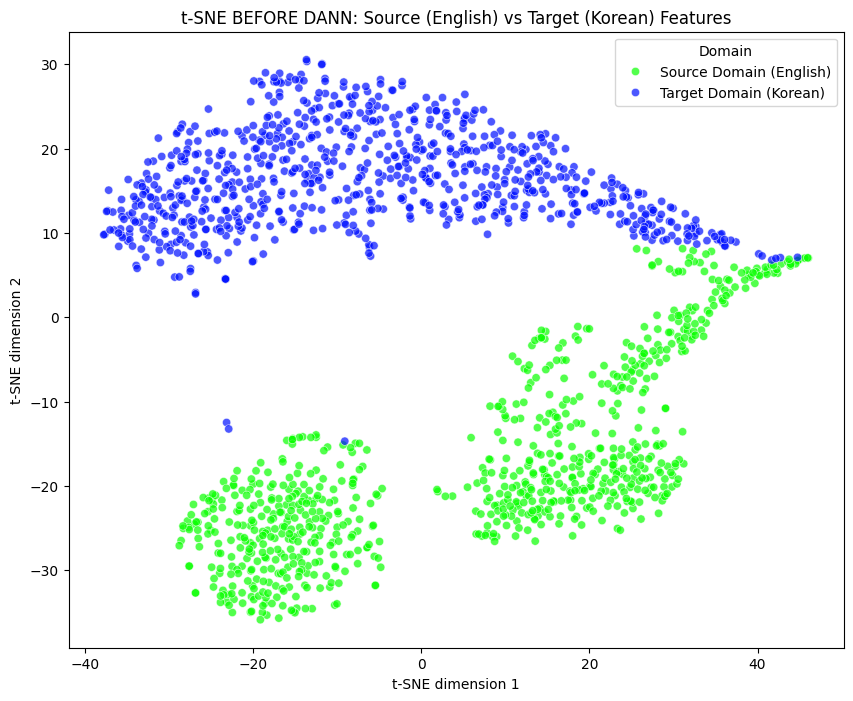

In [ ]:
if 'config' in locals() and 'DEVICE' in locals():
    print("Re-initializing FeatureExtractor to its pre-trained state (before DANN fine-tuning)...")
    feature_extractor_before_training = FeatureExtractor(config.BERT_MODEL_NAME).to(DEVICE)
    print("FeatureExtractor for 'before training' state initialized.")
else:
    print("ERROR: 'config' or 'DEVICE' variable is not defined. Please run the setup cells.")
    feature_extractor_before_training = None

if feature_extractor_before_training and \
   'source_loader' in locals() and \
   'target_train_loader' in locals() and \
   'NUM_TSNE_SAMPLES_PER_DOMAIN' in locals() and \
   callable(get_features_for_tsne) and \
   callable(plot_tsne):

    print("\nExtracting features for t-SNE (BEFORE DANN training)...")

    # 소스 도메인 특징 추출 (학습 전 모델 사용)
    source_features_before, source_domain_labels_before = get_features_for_tsne(
        feature_extractor_before_training,
        source_loader,
        DEVICE,
        num_samples=NUM_TSNE_SAMPLES_PER_DOMAIN
    )
    print(f"Extracted {source_features_before.shape[0]} source features (before training).")

    # 타겟 도메인 특징 추출 (학습 전 모델 사용)
    target_features_before, target_domain_labels_before = get_features_for_tsne(
        feature_extractor_before_training,
        target_train_loader,
        DEVICE,
        num_samples=NUM_TSNE_SAMPLES_PER_DOMAIN
    )
    print(f"Extracted {target_features_before.shape[0]} target features (before training).")

    # 특징 합치기
    if source_features_before.shape[0] > 1 and target_features_before.shape[0] > 1:
        all_features_before_tsne = np.concatenate((source_features_before, target_features_before), axis=0)
        all_domain_labels_before_tsne = np.concatenate((source_domain_labels_before, target_domain_labels_before), axis=0)

        print(f"Total features for t-SNE (before training): {all_features_before_tsne.shape[0]}")

        # t-SNE 시각화 실행
        plot_tsne(all_features_before_tsne,
                  all_domain_labels_before_tsne,
                  title='t-SNE BEFORE DANN: Source (English) vs Target (Korean) Features')
    else:
        print("Not enough features extracted from one or both domains to perform t-SNE (before training).")
        if source_features_before.shape[0] <=1 : print(f"  Source samples: {source_features_before.shape[0]}")
        if target_features_before.shape[0] <=1 : print(f"  Target samples: {target_features_before.shape[0]}")

else:
    if not feature_extractor_before_training:
        print("Skipping 'before training' t-SNE because feature_extractor_before_training was not initialized.")
    else:
        print("ERROR: One or more required variables/functions for 'before training' t-SNE are not defined.")
        print("Please ensure 'source_loader', 'target_train_loader', 'NUM_TSNE_SAMPLES_PER_DOMAIN',")
        print("'get_features_for_tsne', and 'plot_tsne' are available in the current scope.")

### DANN 시각화

In [ ]:
DEVICE = device
if 'model_save_dir' not in globals(): # 이전 셀에서 정의 안 됐을 경우 대비
     model_save_dir = f"{project_path}/{getattr(config, 'MODEL_SAVE_DIR_BASE', 'saved_models')}" # 실제 저장 경로로!
     print(f"Model save/load directory set to: {model_save_dir}")


fe_weights_path = f"{model_save_dir}/feature_extractor_dann.pth" # 에폭 7에서 저장된 파일명
sc_weights_path = f"{model_save_dir}/sentiment_classifier_dann.pth" # 에폭 7에서 저장된 파일명

feature_extractor = FeatureExtractor(config.BERT_MODEL_NAME).to(DEVICE)
sentiment_classifier = SentimentClassifier(feature_extractor.bert_output_dim).to(DEVICE)

try:
    feature_extractor.load_state_dict(torch.load(fe_weights_path, map_location=DEVICE))
    sentiment_classifier.load_state_dict(torch.load(sc_weights_path, map_location=DEVICE))
    print(f"Successfully loaded saved weights for Model (from best performing epoch).")
except Exception as e:
    print(f"ERROR loading saved model weights for pseudo-labeling: {e}.")
    print("Cannot proceed without a teacher model. Please ensure model weights from Epoch 7 (or best) are correctly saved and paths are correct.")
    raise

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Successfully loaded saved weights for Model (from best performing epoch).



Extracting features for t-SNE visualization...
Extracted 800 source features.
Extracted 800 target features.
Total features for t-SNE: 1600
Running t-SNE... (This might take a while for many samples)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


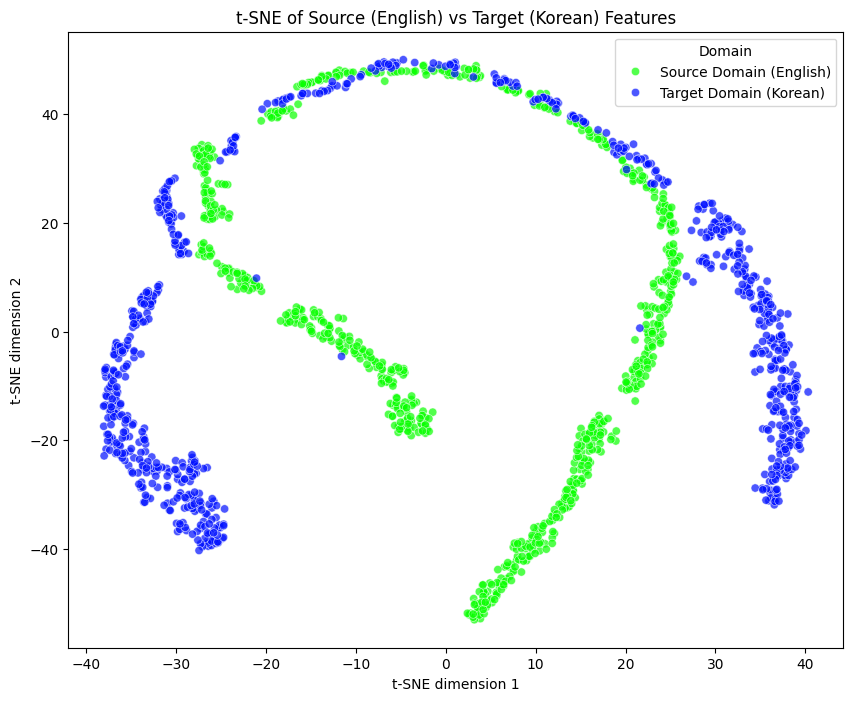

In [ ]:
# t-SNE를 위한 샘플 수 (너무 많으면 오래 걸리고 복잡해짐)
NUM_TSNE_SAMPLES_PER_DOMAIN = 800 # 도메인당 샘플 수
print("\nExtracting features for t-SNE visualization...")

# 소스 도메인 특징 추출
# source_loader는 is_source=True로 생성된 SentimentDataset의 DataLoader여야 함
source_features, source_domain_labels = get_features_for_tsne(
    feature_extractor,
    source_loader,  # 영어 학습 데이터 로더
    DEVICE,
    num_samples=NUM_TSNE_SAMPLES_PER_DOMAIN
)
print(f"Extracted {source_features.shape[0]} source features.")

# 타겟 도메인 특징 추출
# target_train_loader는 is_source=False로 생성된 SentimentDataset의 DataLoader여야 함
target_features, target_domain_labels = get_features_for_tsne(
    feature_extractor,
    target_train_loader, # 한국어 학습 데이터 로더 (또는 target_test_loader 사용 가능)
    DEVICE,
    num_samples=NUM_TSNE_SAMPLES_PER_DOMAIN
)
print(f"Extracted {target_features.shape[0]} target features.")


# 특징 합치기
if source_features.shape[0] > 0 and target_features.shape[0] > 0:
    all_features_for_tsne = np.concatenate((source_features, target_features), axis=0)
    # get_features_for_tsne에서 반환된 domain_labels는 이미 0 또는 1로 되어 있음
    all_domain_labels_for_tsne = np.concatenate((source_domain_labels, target_domain_labels), axis=0)

    print(f"Total features for t-SNE: {all_features_for_tsne.shape[0]}")

    # t-SNE 시각화 실행
    plot_tsne(all_features_for_tsne, all_domain_labels_for_tsne,
              title='t-SNE of Source (English) vs Target (Korean) Features')
else:
    print("Not enough features extracted from one or both domains to perform t-SNE.")

Attempting to load: /content/drive/MyDrive/DA/Train_target.csv
Initial rows: 180000, Columns: ['label', 'text']
Loaded and processed 180000 samples from /content/drive/MyDrive/DA/Train_target.csv.
Loaded 180000 Korean samples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Source samples loaded: 800
Target samples loaded: 800

Extracting features using the provided FeatureExtractor model...
Total samples for t-SNE: 1600
Running t-SNE... (This might take a while for many samples)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


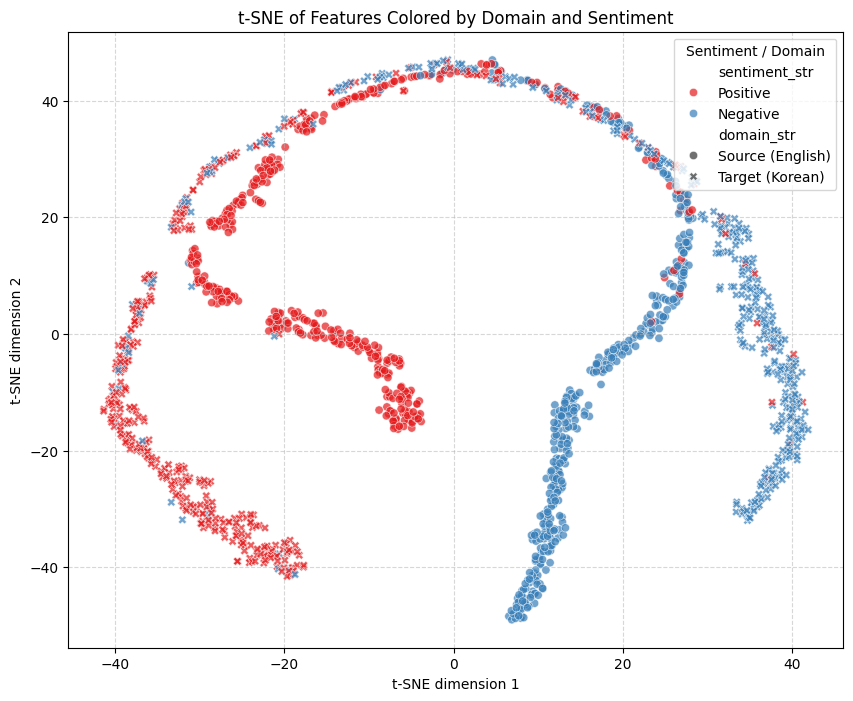

In [ ]:
# === 2. Load IMDB Dataset (Source) ===
MAX_NUM_WORDS = 10000 # Note: This is for the Keras IMDB dataset, not directly used for tokenization
(X_train_en, y_train_en), (X_test_en, y_test_en) = imdb.load_data(num_words=MAX_NUM_WORDS)
word_index = imdb.get_word_index()
index_word = {v+3: k for k, v in word_index.items()}
index_word[0] = '<PAD>'
index_word[1] = '<START>'
index_word[2] = '<UNK>'
index_word[3] = '<UNUSED>'

def decode_review(encoded_review):
    return ' '.join([index_word.get(i, '?') for i in encoded_review])

X_train_en_text = [decode_review(x) for x in X_train_en]
X_test_en_text = [decode_review(x) for x in X_test_en]

# === 3. Load Korean Dataset (Target) ===
if 'project_path' not in globals() and 'project_path' not in locals():
    project_path = '/content/drive/MyDrive/DA' # Fallback, adjust if needed
    print(f"Warning: project_path not found, using default: {project_path}")

# Assuming config is imported and has NAVER_SHOPPING_TRAIN_FILE
import config
kr_file_path = f"{project_path}/{config.NAVER_SHOPPING_TRAIN_FILE}"

X_kr_text, y_kr = load_naver_shopping_reviews(kr_file_path, sample_size=None) # Load all for t-SNE

print(f"Loaded {len(X_kr_text)} Korean samples.")


# === 4. Tokenizer and Dataset Definition ===
MODEL_NAME = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 128

class SentimentDataset(Dataset):
    def __init__(self, texts, labels=None, is_source=False): # Added is_source for domain label
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=MAX_LEN)
        self.labels = labels
        # Add domain labels: 0 for source, 1 for target
        self.domain_labels = [0 if is_source else 1] * len(texts)


    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        # Include domain label in the item
        item['domain_labels'] = torch.tensor(self.domain_labels[idx], dtype=torch.long) # Use long for domain label

        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# === 5. Split and Loaders ===
from torch.utils.data import Subset
NUM_SAMPLES = 800

# Create datasets with is_source flag
source_dataset = SentimentDataset(X_train_en_text, y_train_en, is_source=True)
target_dataset = SentimentDataset(X_kr_text, y_kr, is_source=False) # Pass actual labels if available for target

# Create subsets for t-SNE visualization
# Use Subset to sample specific number of data points
source_subset = Subset(source_dataset, list(range(min(NUM_SAMPLES, len(source_dataset)))))
target_subset = Subset(target_dataset, list(range(min(NUM_SAMPLES, len(target_dataset)))))

source_loader = DataLoader(source_subset, batch_size=32, shuffle=False) # Shuffle=False for consistent sampling
target_loader = DataLoader(target_subset, batch_size=32, shuffle=False) # Shuffle=False for consistent sampling

print(f"Source samples loaded: {len(source_subset)}")
print(f"Target samples loaded: {len(target_subset)}")


# === 6. FeatureExtractor Function ===
def extract_features(model, dataloader, device, num_samples=None):
    """지정된 수의 샘플에 대해 특징 벡터, 감성 레이블, 도메인 레이블을 추출합니다."""
    model.eval() # 평가 모드

    all_features = []
    all_sentiment_labels = []
    all_domain_labels = []

    count = 0
    with torch.no_grad():
        for batch in dataloader:
            # Limit samples if num_samples is specified
            if num_samples is not None and count >= num_samples:
                break

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            domain_labels_batch = batch['domain_labels'].cpu().numpy()

            features = model(input_ids, attention_mask) # Assuming model is just FeatureExtractor

            # Handle sentiment labels (may not exist for unlabeled target data)
            sentiment_labels_batch = batch.get('labels', torch.full_like(batch['domain_labels'], -1)).cpu().numpy()

            # Adjust samples to take if near the limit
            current_batch_size = features.size(0)
            samples_to_take = min(current_batch_size, (num_samples - count) if num_samples is not None else current_batch_size)

            all_features.append(features[:samples_to_take].cpu().numpy())
            all_sentiment_labels.append(sentiment_labels_batch[:samples_to_take])
            all_domain_labels.append(domain_labels_batch[:samples_to_take])

            count += samples_to_take

    all_features = np.concatenate(all_features, axis=0)
    all_sentiment_labels = np.concatenate(all_sentiment_labels, axis=0)
    all_domain_labels = np.concatenate(all_domain_labels, axis=0)

    return all_features, all_sentiment_labels, all_domain_labels


# === 7. t-SNE Visualization Function ===
def plot_tsne_domain_sentiment(features, sentiments, domains, title='t-SNE by Domain and Sentiment'):
    """t-SNE 결과를 시각화합니다."""
    print("Running t-SNE... (This might take a while for many samples)")
    # Adjust perplexity if num_samples is small
    perplexity_val = min(30, max(5, features.shape[0] - 1))

    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, n_iter=1000, learning_rate='auto')
    tsne_results = tsne.fit_transform(features)

    df = pd.DataFrame({
        'x': tsne_results[:, 0],
        'y': tsne_results[:, 1],
        'sentiment': sentiments,
        'domain': domains
    })

    # Map integer labels to meaningful strings
    df['sentiment_str'] = df['sentiment'].map({0: 'Negative', 1: 'Positive', -1: 'Unknown'})
    df['domain_str'] = df['domain'].map({0: 'Source (English)', 1: 'Target (Korean)'})

    plt.figure(figsize=(10, 8))
    # Use 'sentiment_str' for hue and 'domain_str' for style
    sns.scatterplot(data=df, x='x', y='y', hue='sentiment_str', style='domain_str', palette='Set1', alpha=0.7)
    plt.title(title)
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.legend(title='Sentiment / Domain')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# === 8. Execution (Requires Feature Extractor Model) ===
if 'feature_extractor' in locals() and feature_extractor is not None:
    print("\nExtracting features using the provided FeatureExtractor model...")
    source_feats, source_sents, source_domains = extract_features(feature_extractor, source_loader, device, num_samples=NUM_SAMPLES)
    target_feats, target_sents, target_domains = extract_features(feature_extractor, target_loader, device, num_samples=NUM_SAMPLES)

    # Concatenate features and labels
    all_feats = np.concatenate((source_feats, target_feats))
    all_sents = np.concatenate((source_sents, target_sents))
    all_domains = np.concatenate((source_domains, target_domains))

    print(f"Total samples for t-SNE: {all_feats.shape[0]}")

    # Plot t-SNE
    plot_tsne_domain_sentiment(all_feats, all_sents, all_domains,
                               title='t-SNE of Features Colored by Domain and Sentiment')
else:
    print("Error: Feature Extractor model not found. Please ensure 'feature_extractor' is defined.")

### DANN + Free Match 시각화


Extracting features for t-SNE visualization...
Extracted 800 source features.
Extracted 800 target features.
Total features for t-SNE: 1600
Running t-SNE... (This might take a while for many samples)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


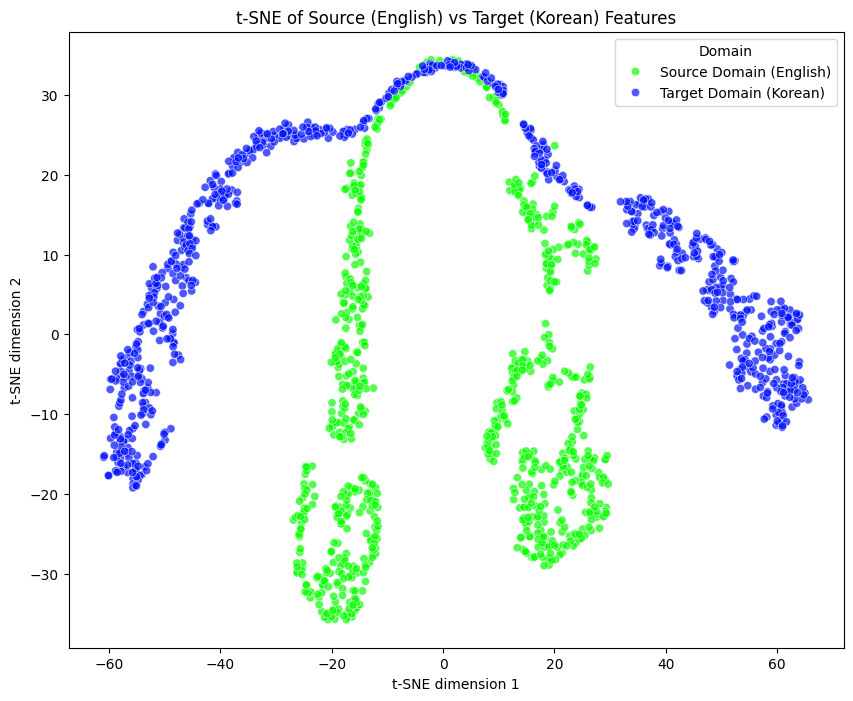

In [ ]:
# t-SNE를 위한 샘플 수
NUM_TSNE_SAMPLES_PER_DOMAIN = 800 # 도메인당 샘플 수

print("\nExtracting features for t-SNE visualization...")

# 소스 도메인 특징 추출
# source_loader는 is_source=True로 생성된 SentimentDataset의 DataLoader여야 함
source_features, source_domain_labels = get_features_for_tsne(
    feature_extractor,
    source_loader,  # 영어 학습 데이터 로더
    DEVICE,
    num_samples=NUM_TSNE_SAMPLES_PER_DOMAIN
)
print(f"Extracted {source_features.shape[0]} source features.")

# 타겟 도메인 특징 추출
# target_train_loader는 is_source=False로 생성된 SentimentDataset의 DataLoader여야 함
target_features, target_domain_labels = get_features_for_tsne(
    feature_extractor,
    target_train_loader, # 한국어 학습 데이터 로더 (또는 target_test_loader 사용 가능)
    DEVICE,
    num_samples=NUM_TSNE_SAMPLES_PER_DOMAIN
)
print(f"Extracted {target_features.shape[0]} target features.")


# 특징 합치기
if source_features.shape[0] > 0 and target_features.shape[0] > 0:
    all_features_for_tsne = np.concatenate((source_features, target_features), axis=0)
    # get_features_for_tsne에서 반환된 domain_labels는 이미 0 또는 1로 되어 있음
    all_domain_labels_for_tsne = np.concatenate((source_domain_labels, target_domain_labels), axis=0)

    print(f"Total features for t-SNE: {all_features_for_tsne.shape[0]}")

    # t-SNE 시각화 실행
    plot_tsne(all_features_for_tsne, all_domain_labels_for_tsne,
              title='t-SNE of Source (English) vs Target (Korean) Features')
else:
    print("Not enough features extracted from one or both domains to perform t-SNE.")

Attempting to load: /content/drive/MyDrive/DA/Train_target.csv
Initial rows: 180000, Columns: ['label', 'text']
Loaded and processed 180000 samples from /content/drive/MyDrive/DA/Train_target.csv.
Loaded 180000 Korean samples.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Source samples loaded: 800
Target samples loaded: 800

Extracting features using the provided FeatureExtractor model...
Total samples for t-SNE: 1600
Running t-SNE... (This might take a while for many samples)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


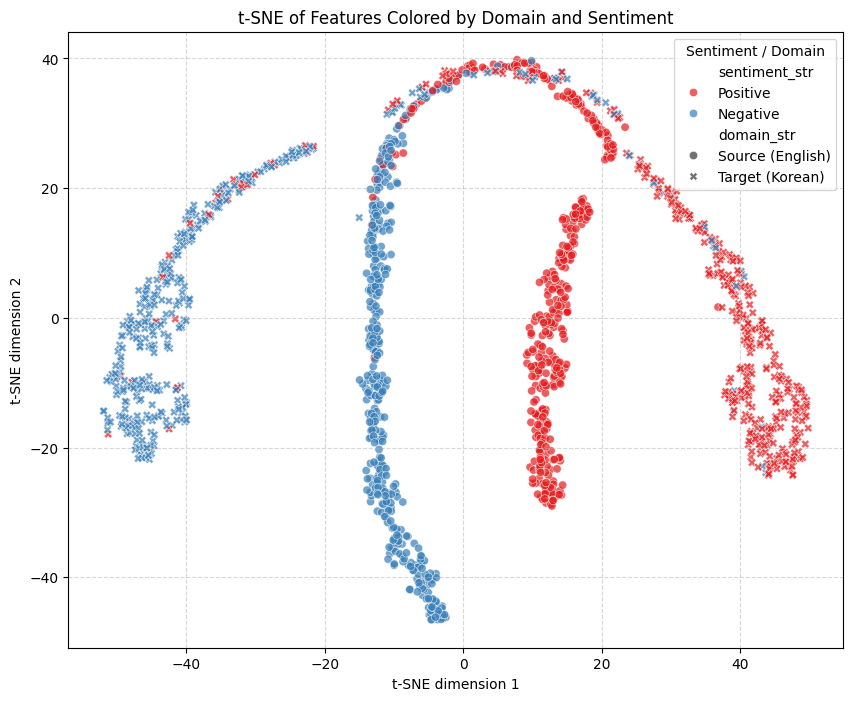

In [ ]:
# === 1. Imports and Config ===

# === 2. Load IMDB Dataset (Source) ===
MAX_NUM_WORDS = 10000 # Note: This is for the Keras IMDB dataset, not directly used for tokenization
(X_train_en, y_train_en), (X_test_en, y_test_en) = imdb.load_data(num_words=MAX_NUM_WORDS)
word_index = imdb.get_word_index()
index_word = {v+3: k for k, v in word_index.items()}
index_word[0] = '<PAD>'
index_word[1] = '<START>'
index_word[2] = '<UNK>'
index_word[3] = '<UNUSED>'

def decode_review(encoded_review):
    return ' '.join([index_word.get(i, '?') for i in encoded_review])

X_train_en_text = [decode_review(x) for x in X_train_en]
X_test_en_text = [decode_review(x) for x in X_test_en]

# === 3. Load Korean Dataset (Target) ===
if 'project_path' not in globals() and 'project_path' not in locals():
    project_path = '/content/drive/MyDrive/DA' # Fallback, adjust if needed
    print(f"Warning: project_path not found, using default: {project_path}")

# Assuming config is imported and has NAVER_SHOPPING_TRAIN_FILE
import config
kr_file_path = f"{project_path}/{config.NAVER_SHOPPING_TRAIN_FILE}"

# Load the Korean training data using the dedicated function
# The function returns texts and labels directly
X_kr_text, y_kr = load_naver_shopping_reviews(kr_file_path, sample_size=None) # Load all for t-SNE

print(f"Loaded {len(X_kr_text)} Korean samples.")


# === 4. Tokenizer and Dataset Definition ===
MODEL_NAME = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 128

class SentimentDataset(Dataset):
    def __init__(self, texts, labels=None, is_source=False): # Added is_source for domain label
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=MAX_LEN)
        self.labels = labels
        # Add domain labels: 0 for source, 1 for target
        self.domain_labels = [0 if is_source else 1] * len(texts)


    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        # Include domain label in the item
        item['domain_labels'] = torch.tensor(self.domain_labels[idx], dtype=torch.long) # Use long for domain label

        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# === 5. Split and Loaders ===
from torch.utils.data import Subset
NUM_SAMPLES = 800

# Create datasets with is_source flag
source_dataset = SentimentDataset(X_train_en_text, y_train_en, is_source=True)
target_dataset = SentimentDataset(X_kr_text, y_kr, is_source=False) # Pass actual labels if available for target

# Create subsets for t-SNE visualization
# Use Subset to sample specific number of data points
source_subset = Subset(source_dataset, list(range(min(NUM_SAMPLES, len(source_dataset)))))
target_subset = Subset(target_dataset, list(range(min(NUM_SAMPLES, len(target_dataset)))))

source_loader = DataLoader(source_subset, batch_size=32, shuffle=False) # Shuffle=False for consistent sampling
target_loader = DataLoader(target_subset, batch_size=32, shuffle=False) # Shuffle=False for consistent sampling

print(f"Source samples loaded: {len(source_subset)}")
print(f"Target samples loaded: {len(target_subset)}")


# === 6. FeatureExtractor Function ===
def extract_features(model, dataloader, device, num_samples=None):
    """지정된 수의 샘플에 대해 특징 벡터, 감성 레이블, 도메인 레이블을 추출합니다."""
    model.eval() # 평가 모드

    all_features = []
    all_sentiment_labels = []
    all_domain_labels = []

    count = 0
    with torch.no_grad():
        for batch in dataloader:
            # Limit samples if num_samples is specified
            if num_samples is not None and count >= num_samples:
                break

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            domain_labels_batch = batch['domain_labels'].cpu().numpy()

            features = model(input_ids, attention_mask) # Assuming model is just FeatureExtractor

            # Handle sentiment labels (may not exist for unlabeled target data)
            sentiment_labels_batch = batch.get('labels', torch.full_like(batch['domain_labels'], -1)).cpu().numpy()

            # Adjust samples to take if near the limit
            current_batch_size = features.size(0)
            samples_to_take = min(current_batch_size, (num_samples - count) if num_samples is not None else current_batch_size)

            all_features.append(features[:samples_to_take].cpu().numpy())
            all_sentiment_labels.append(sentiment_labels_batch[:samples_to_take])
            all_domain_labels.append(domain_labels_batch[:samples_to_take])

            count += samples_to_take

    all_features = np.concatenate(all_features, axis=0)
    all_sentiment_labels = np.concatenate(all_sentiment_labels, axis=0)
    all_domain_labels = np.concatenate(all_domain_labels, axis=0)

    return all_features, all_sentiment_labels, all_domain_labels


# === 7. t-SNE Visualization Function ===
def plot_tsne_domain_sentiment(features, sentiments, domains, title='t-SNE by Domain and Sentiment'):
    """t-SNE 결과를 시각화합니다."""
    print("Running t-SNE... (This might take a while for many samples)")
    # Adjust perplexity if num_samples is small
    perplexity_val = min(30, max(5, features.shape[0] - 1))

    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, n_iter=1000, learning_rate='auto')
    tsne_results = tsne.fit_transform(features)

    df = pd.DataFrame({
        'x': tsne_results[:, 0],
        'y': tsne_results[:, 1],
        'sentiment': sentiments,
        'domain': domains
    })

    # Map integer labels to meaningful strings
    df['sentiment_str'] = df['sentiment'].map({0: 'Negative', 1: 'Positive', -1: 'Unknown'})
    df['domain_str'] = df['domain'].map({0: 'Source (English)', 1: 'Target (Korean)'})

    plt.figure(figsize=(10, 8))
    # Use 'sentiment_str' for hue and 'domain_str' for style
    sns.scatterplot(data=df, x='x', y='y', hue='sentiment_str', style='domain_str', palette='Set1', alpha=0.7)
    plt.title(title)
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.legend(title='Sentiment / Domain')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# === 8. Execution (Requires Feature Extractor Model) ===
if 'feature_extractor' in locals() and feature_extractor is not None:
    print("\nExtracting features using the provided FeatureExtractor model...")
    source_feats, source_sents, source_domains = extract_features(feature_extractor, source_loader, device, num_samples=NUM_SAMPLES)
    target_feats, target_sents, target_domains = extract_features(feature_extractor, target_loader, device, num_samples=NUM_SAMPLES)

    # Concatenate features and labels
    all_feats = np.concatenate((source_feats, target_feats))
    all_sents = np.concatenate((source_sents, target_sents))
    all_domains = np.concatenate((source_domains, target_domains))

    print(f"Total samples for t-SNE: {all_feats.shape[0]}")

    # Plot t-SNE
    plot_tsne_domain_sentiment(all_feats, all_sents, all_domains,
                               title='t-SNE of Features Colored by Domain and Sentiment')
else:
    print("Error: Feature Extractor model not found. Please ensure 'feature_extractor' is defined.")